In [ ]:
%cd ..

In [ ]:
import os
import pickle
from experiments_reproduction.experiments_module import Experiment
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from typing import List, Dict
import copy
import networkx as nx

# Utility functions for extracting results

In [3]:
def get_n_swaps_entropy_results(experiments, n_swpas):
    

    def get_dict_stats(data):
        # Compute averages for each dictionary
        averages = [np.mean(list(d.values())) for d in data]

        # Compute overall mean and standard deviation
        mean = np.mean(averages)
        std = np.std(averages)

        return {"mean": mean, "std": std}

    
    ee_results = []
    surrogate_results = []
    for ns in n_swaps:
        ee_results_temp = []
        surrogate_results_temp = []

        for experiment in experiments:
            ns_node = experiment.get_n_swaps_nodes(n_swaps=ns)[0]
            entropy_measurement_results = experiment.get_entropy_measurement_results(node=ns_node)
            ee_results_temp.append(entropy_measurement_results['ave_canonical_at_levels'].entropy_at_level)
            surrogate_results_temp.append(entropy_measurement_results['ave_surrogate_canonical_at_levels'].entropy_at_level)
        ee_results.append(ee_results_temp)
        surrogate_results.append(surrogate_results_temp)

    ee_results = [get_dict_stats(temp_result) for temp_result in ee_results]
    surrogate_results = [get_dict_stats(temp_result) for temp_result in surrogate_results]
    
    return ee_results, surrogate_results


def get_n_swaps_baseline_results(experiments, n_swpas, baseline):
    
    def mean_std_sublist(lst):
        results = []
        for sub_lst in lst:
            arr = np.array(sub_lst)
            mean = np.mean(arr)
            std = np.std(arr)
            results.append({"mean": mean, "std": std})
        return results
    
    train_results = []
    test_results = []
    for ns in n_swaps:
        train_results_temp = []
        test_results_temp = []

        for experiment in experiments:
            ns_node = experiment.get_n_swaps_nodes(n_swaps=ns)[0]
            baseline_measurement_results = experiment.get_baseline_results(node=ns_node)
            train_results_temp.append(baseline_measurement_results[baseline].train_acc)
            test_results_temp.append(baseline_measurement_results[baseline].test_acc)
        train_results.append(train_results_temp)
        test_results.append(test_results_temp)
    
    return mean_std_sublist(train_results), mean_std_sublist(test_results)




def load_experiments_from_folder(src_folder):
    """
    Given a source folder, loads all .pkl objects in the folder and
    appends them to a list, then returns that list.
    """
    # create an empty list to hold the loaded objects
    loaded_objects = []

    # loop over all the files in the folder
    for filename in os.listdir(src_folder):
        # check if the file is a pickle file
        if filename.endswith('.pkl'):
            # load the pickle file and append it to the list
            with open(os.path.join(src_folder, filename), 'rb') as f:
                loaded_objects.append(pickle.load(f))

    # return the list of loaded objects
    return loaded_objects

def get_baseline_mean_std(experiments, node, baselines):
    results = {}
    for baseline in baselines:
        test_accs = []
        for e in experiments:
            test_accs.append(e.get_baseline_results(node=node)[baseline].test_acc)
        results[baseline] = {'mean': np.mean(test_accs), 'std': np.std(test_accs)}
    
    return results

# Plotting utility functions

In [4]:
def plot_error_envelopes(x: List[int], left_data: List[Dict[str, float]], right_data: Dict[str, List[Dict[str, float]]], save_path: str = None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18.3, 4.5))

    # Prepare left plot data
    left_means = [data['mean'] for data in left_data]
    left_stds = [data['std'] for data in left_data]

    # Plot left data
    ax1.plot(x, left_means, 'r-', marker='o', linewidth=2)
    ax1.fill_between(x, [mean - std for mean, std in zip(left_means, left_stds)], [mean + std for mean, std in zip(left_means, left_stds)], alpha=0.2, edgecolor='r', facecolor='r')
    ax1.set_ylabel('Entanglement Under \n Canonical Partitions', fontsize=19)
    ax1.tick_params('y', labelsize=18)
    ax1.tick_params('x', labelsize=18)

    # Prepare colors, markers, and styles
    colors = ['b', 'g', 'm', 'y', 'k', 'r', 'c']
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*']
    styles = ['-', '--', '-.', ':', 'None']

    # Plot right data
    for i, (model, data) in enumerate(right_data.items()):
        right_means = [entry['mean'] * 100 for entry in data]
        right_stds = [entry['std'] * 100 for entry in data]

        current_color = colors[i % len(colors)]
        ax2.plot(x, right_means, color=current_color, linestyle=styles[i % len(styles)], marker=markers[i % len(markers)], label=model, linewidth=2)
        ax2.fill_between(x, [mean - std for mean, std in zip(right_means, right_stds)], [mean + std for mean, std in zip(right_means, right_stds)], alpha=0.2, edgecolor=current_color, facecolor=current_color)
    
    ax2.set_ylabel('Test Accuracy (%)', fontsize=19)
    ax2.tick_params('y', labelsize=18)
    ax2.tick_params('x', labelsize=18)
    ax2.yaxis.tick_left()
    ax2.yaxis.set_label_position("left")
    ax2.legend(loc=1, fontsize=15)

    # Set axis labels and limits
    epsilon = 18
    ax1.set_xlabel('Number of Feature Swaps in Data', fontsize=19)
    ax2.set_xlabel('Number of Feature Swaps in Data', fontsize=19)
    ax1.set_xlim(x[0] - epsilon, x[-1] + epsilon)
    ax2.set_xlim(x[0] - epsilon, x[-1] + epsilon)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, format='pdf', dpi=300)

    plt.show()

def plot_bottom_subplot(x, y2_data, y3_data, x_name="Number of Feature Swaps in Data",
                        y2_name="Entanglement Under \n Canonical Partitions", 
                        y3_name="Surrogate Entanglement \n Under Canonical Partitions",
                        save_path: str = None):

    y2 = [[d['mean'] for d in y2_data], [d['std'] for d in y2_data]]
    y3 = [[d['mean'] for d in y3_data], [d['std'] for d in y3_data]]

    markers = ['o', 'v']
    colors = ['b', 'g']

#     fig, ax2 = plt.subplots(figsize=(16.2, 7))
    fig, ax2 = plt.subplots(figsize=(950.4 / 72, 360.0 / 72))

    ax2.plot(x, y2[0], '-', color=colors[0], marker = markers[0], label="Entanglement")
    ax2.fill_between(x, [y2[0][i] - y2[1][i] for i in range(len(y2[0]))], [y2[0][i] + y2[1][i] for i in range(len(y2[0]))], alpha=0.2, edgecolor='b', facecolor='b')
    ax2.set_ylabel(y2_name, fontsize=18)
    ax2.yaxis.set_label_coords(-0.065, 0.5)
    ax2.tick_params('y', labelsize=18)
    ax2.tick_params('x', labelsize=18)

    ax2_right = ax2.twinx()
    ax2_right.plot(x, y3[0], '-', color=colors[1], marker = markers[1], label="Surrogate Entanglement")
    ax2_right.fill_between(x, [y3[0][i] - y3[1][i] for i in range(len(y3[0]))], [y3[0][i] + y3[1][i] for i in range(len(y3[0]))], alpha=0.2, edgecolor='k', facecolor='k')
    ax2_right.yaxis.set_tick_params(labelright=True, labelleft=False)
    ax2_right.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

    ax2_right.set_ylabel(y3_name, fontsize=18)
    ax2_right.yaxis.set_label_coords(1.138, 0.5)
    ax2_right.tick_params('y', labelsize=18)

    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_right.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc = 'upper left', fontsize=16)

    for i in range(len(x)):
        plt.axvline(x[i], color='k', linestyle='--', alpha=0.2)

    ax2.set_xlabel(x_name, fontsize=18)

    plt.xlim(x[0] - 18, x[-1] + 18)
    fig.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, format='pdf', dpi=300)
    
    plt.show()
    


def plot_table(data, name_mapping, title=None):
    methods = list(data.keys())
    models = list(data[methods[0]].keys())
    mapped_model_names = [name_mapping[model] for model in models]

    cell_text = []
    for model in models:
        row = []
        for method in methods:
            mean = data[method][model]['mean'] * 100.0
            std = data[method][model]['std'] * 100.0
            row.append(f"{mean:.4f} ± {std:.4f}")
        cell_text.append(row)

    fig, ax = plt.subplots()
    
    ax.axis('off')

    table = ax.table(cellText=cell_text,
                     rowLabels=mapped_model_names,
                     colLabels=methods,
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    if title:
        plt.title(title)
    plt.show()

# Figure 8

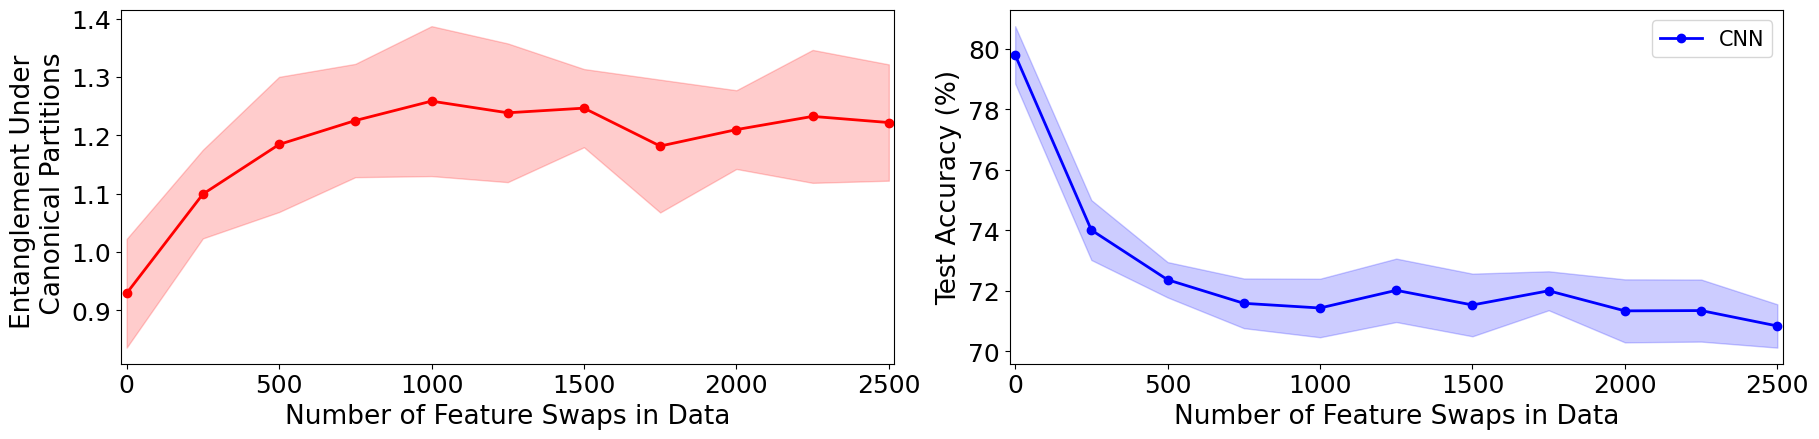

In [5]:
src_folder = "experiments_reproduction/cache_dirs/figure_8_cache_dir"
src_folder = os.path.join(os.getcwd(), src_folder)

experiments = load_experiments_from_folder(src_folder)
n_swaps = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]

ee_results = get_n_swaps_entropy_results(experiments, n_swaps)[0]

baseline_results_cnn = get_n_swaps_baseline_results(experiments, n_swaps, 'cnn_baseline')[1]
baseline_results = {"CNN": baseline_results_cnn}

plot_error_envelopes(n_swaps, ee_results, baseline_results)

# Figure 4

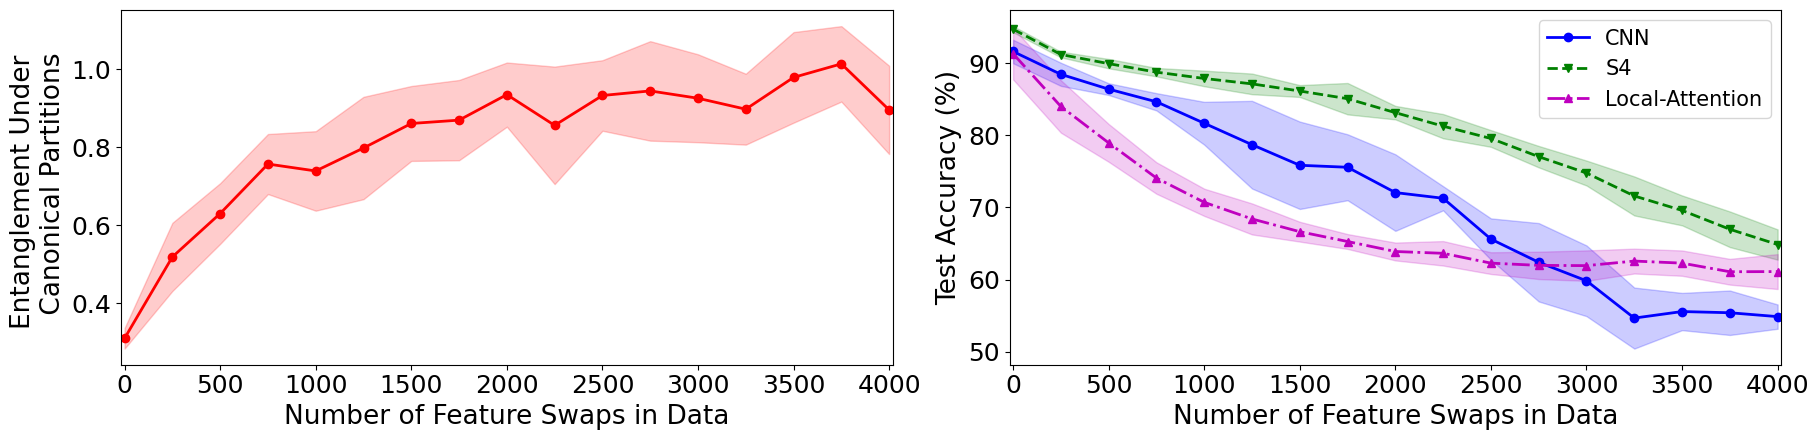

In [13]:
src_folder = "experiments_reproduction/cache_dirs/figure_4_ache_dir"
src_folder = os.path.join(os.getcwd(), src_folder)

experiments = load_experiments_from_folder(src_folder)

n_swaps = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000]

ee_results, surrogate_results = get_n_swaps_entropy_results(experiments, n_swaps)

baseline_results_cnn = get_n_swaps_baseline_results(experiments, n_swaps, 'cnn_baseline')[1]
baseline_results_s4 = get_n_swaps_baseline_results(experiments, n_swaps, 's4_baseline')[1]
baseline_results_lat = get_n_swaps_baseline_results(experiments, n_swaps, 'lat_baseline')[1]
baseline_results = {"CNN": baseline_results_cnn, "S4": baseline_results_s4, "Local-Attention": baseline_results_lat}

plot_error_envelopes(n_swaps, ee_results, baseline_results)

## Figure 5

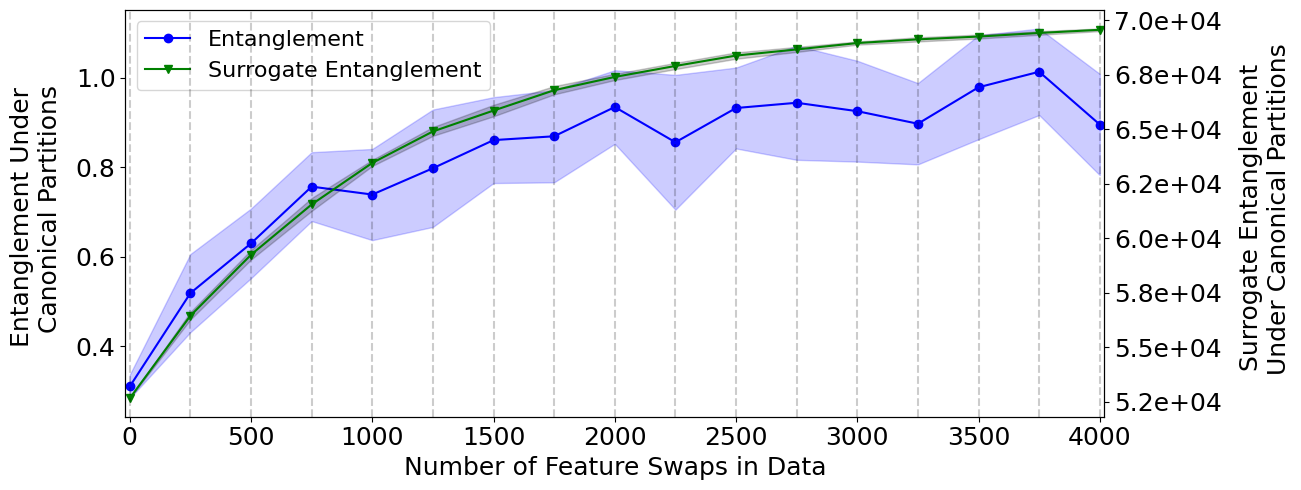

In [14]:
ee_results, surrogate_results = get_n_swaps_entropy_results(experiments, n_swaps)

plot_bottom_subplot(n_swaps, ee_results, surrogate_results)

# Table 1

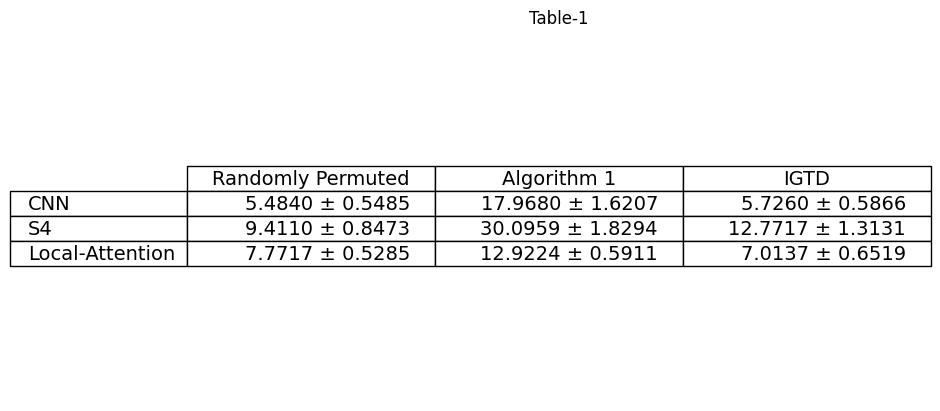

In [8]:
src_folder = "experiments_reproduction/cache_dirs/table_1_cache_dir"
src_folder = os.path.join(os.getcwd(), src_folder)


experiments = load_experiments_from_folder(src_folder)

randomly_permuted_test = get_baseline_mean_std(experiments, 1, ['cnn_baseline', 's4_baseline', 'lat_baseline'])
cuts_rearrangement_test = get_baseline_mean_std(experiments, 2, ['cnn_baseline', 's4_baseline', 'lat_baseline'])
igtd_rearrangement_test = get_baseline_mean_std(experiments, 3, ['cnn_baseline', 's4_baseline', 'lat_baseline'])


name_mapping = {"cnn_baseline": "CNN", "s4_baseline": "S4", "lat_baseline": "Local-Attention"}

baseline_results = {"Randomly Permuted": randomly_permuted_test, "Algorithm 1": cuts_rearrangement_test, 
                   "IGTD": igtd_rearrangement_test}

plot_table(baseline_results, name_mapping, "Table-1")


 # Table 3

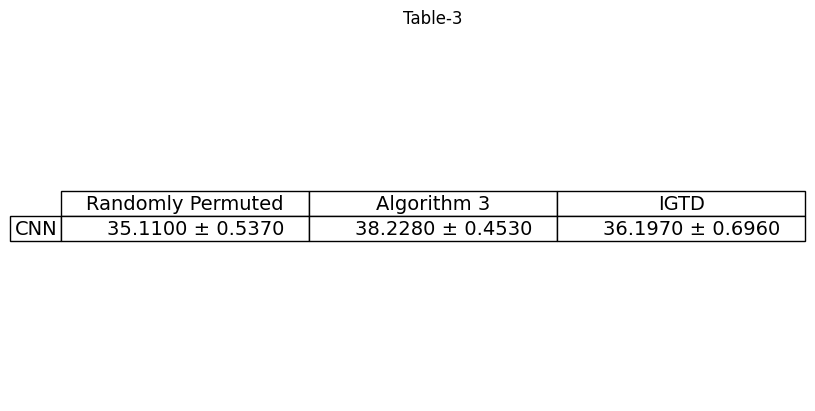

In [9]:
src_folder = "experiments_reproduction/cache_dirs/table_3_cache_dir"
src_folder = os.path.join(os.getcwd(), src_folder)

experiments = load_experiments_from_folder(src_folder)

randomly_permuted_test = get_baseline_mean_std(experiments, 1, ["cnn2d_baseline"])
cuts_rearrangement_test = get_baseline_mean_std(experiments, 2, ["cnn2d_baseline"])
igtd_rearrangement_test = get_baseline_mean_std(experiments, 3, ["cnn2d_baseline"])

baseline_results = {"Randomly Permuted": randomly_permuted_test, "Algorithm 3": cuts_rearrangement_test, 
                   "IGTD": igtd_rearrangement_test}
name_mapping = {"cnn2d_baseline": "CNN"}

plot_table(baseline_results, name_mapping, "Table-3")

# Table 2

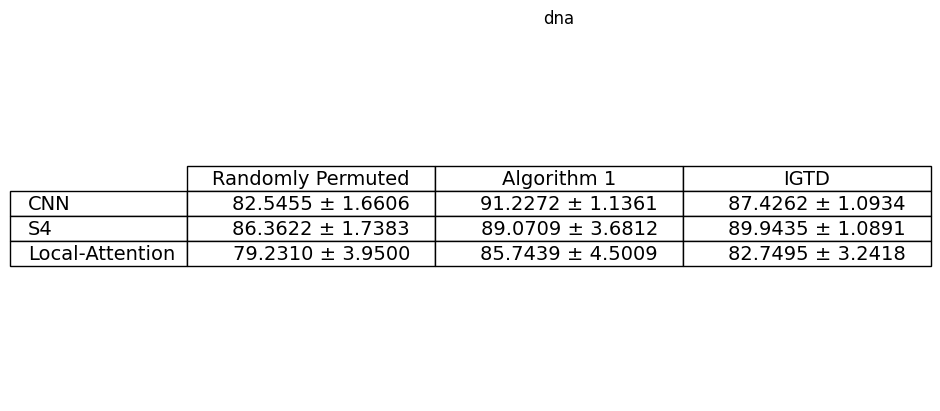

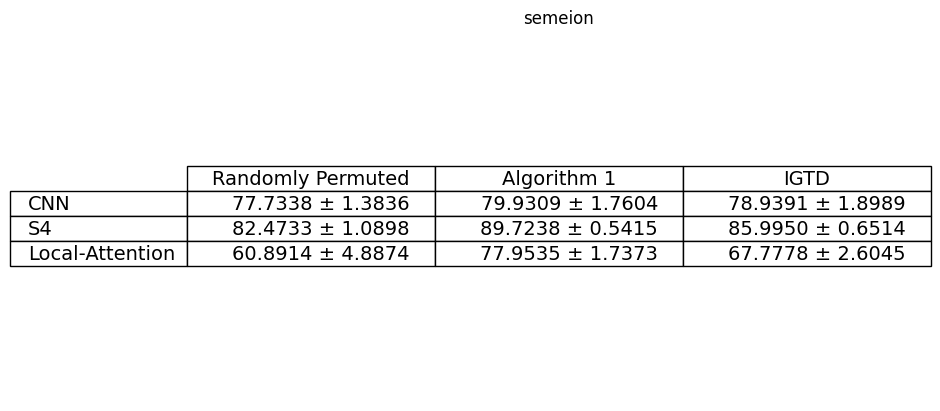

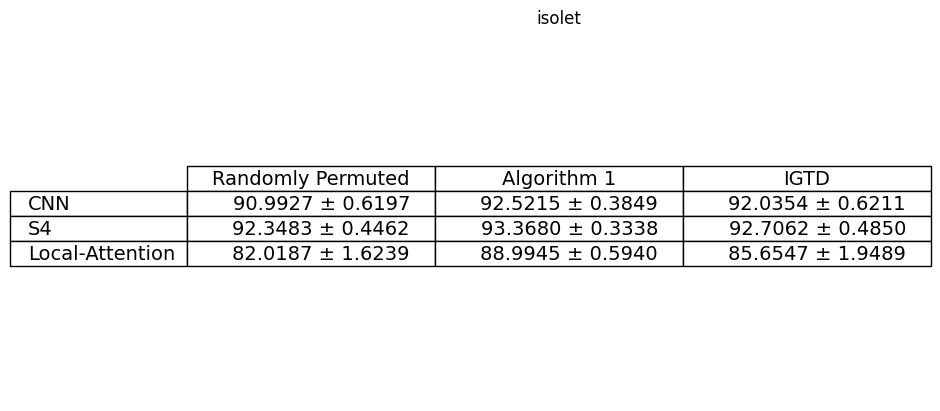

In [10]:
src_folder_dna = "experiments_reproduction/cache_dirs/table_2_dna_cache_dir"
src_folder_dna = os.path.join(os.getcwd(), src_folder_dna)

src_folder_semeion = "experiments_reproduction/cache_dirs/table_2_semeion_cache_dir"
src_folder_semeion = os.path.join(os.getcwd(), src_folder_semeion)

src_folder_isolet = "experiments_reproduction/cache_dirs/table_2_isolet_cache_dir"
src_folder_isolet = os.path.join(os.getcwd(), src_folder_isolet)

experiments_dna = load_experiments_from_folder(src_folder_dna)
experiments_semeion = load_experiments_from_folder(src_folder_semeion)
experiments_isolet = load_experiments_from_folder(src_folder_isolet)

randomly_permuted_test_dna = get_baseline_mean_std(experiments_dna, 1, ['cnn_baseline', 's4_baseline', 'lat_baseline'])
cuts_rearrangement_test_dna = get_baseline_mean_std(experiments_dna, 5, ['cnn_baseline', 's4_baseline', 'lat_baseline'])
igtd_rearrangement_test_dna = get_baseline_mean_std(experiments_dna, 9, ['cnn_baseline', 's4_baseline', 'lat_baseline'])

randomly_permuted_test_semeion = get_baseline_mean_std(experiments_semeion, 1, ['cnn_baseline', 's4_baseline', 'lat_baseline'])
cuts_rearrangement_test_semeion = get_baseline_mean_std(experiments_semeion, 5, ['cnn_baseline', 's4_baseline', 'lat_baseline'])
igtd_rearrangement_test_semeion = get_baseline_mean_std(experiments_semeion, 9, ['cnn_baseline', 's4_baseline', 'lat_baseline'])

randomly_permuted_test_isolet = get_baseline_mean_std(experiments_isolet, 1, ['cnn_baseline', 's4_baseline', 'lat_baseline'])
cuts_rearrangement_test_isolet = get_baseline_mean_std(experiments_isolet, 5, ['cnn_baseline', 's4_baseline', 'lat_baseline'])
igtd_rearrangement_test_isolet = get_baseline_mean_std(experiments_isolet, 9, ['cnn_baseline', 's4_baseline', 'lat_baseline'])


name_mapping = {"cnn_baseline": "CNN", "s4_baseline": "S4", "lat_baseline": "Local-Attention"}

baseline_results_dna = {"Randomly Permuted": randomly_permuted_test_dna, "Algorithm 1": cuts_rearrangement_test_dna, 
                   "IGTD": igtd_rearrangement_test_dna}

baseline_results_semeion = {"Randomly Permuted": randomly_permuted_test_semeion, "Algorithm 1": cuts_rearrangement_test_semeion, 
                   "IGTD": igtd_rearrangement_test_semeion}


baseline_results_isolet = {"Randomly Permuted": randomly_permuted_test_isolet, "Algorithm 1": cuts_rearrangement_test_isolet, 
                   "IGTD": igtd_rearrangement_test_isolet}

plot_table(baseline_results_dna, name_mapping, "dna")
plot_table(baseline_results_semeion, name_mapping, "semeion")
plot_table(baseline_results_isolet, name_mapping, "isolet")

 # Table 4

In [ ]:
src_folder = "experiments_reproduction/cache_dirs/table_4_cache_dir"
src_folder = os.path.join(os.getcwd(), src_folder)

experiments = load_experiments_from_folder(src_folder)

randomly_permuted_test = get_baseline_mean_std(experiments, 1, ["cnn_baseline", "s4_baseline"])
cuts_rearrangement_test = get_baseline_mean_std(experiments, 2, ["cnn_baseline", "s4_baseline"])

baseline_results = {"Randomly Permuted": randomly_permuted_test, "Algorithm 1": cuts_rearrangement_test}
name_mapping = {"cnn_baseline": "CNN", "s4_baseline": "S4"}

plot_table(baseline_results, name_mapping, "Table-4")